Programme de Deep Learning 

Librairies

In [3]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

'ok'

'ok'

(494, 3, 111)


C:\Users\ste0041761\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 491 samples, validate on 3 samples
Epoch 1/100
491/491 [==============================] - 2s 5ms/step - loss: 0.0880 - val_loss: 0.0732
Epoch 2/100
491/491 [==============================] - 2s 3ms/step - loss: 0.0624 - val_loss: 0.0556
Epoch 3/100
491/491 [==============================] - 2s 3ms/step - loss: 0.0573 - val_loss: 0.0777
Epoch 4/100
491/491 [==============================] - 2s 3ms/step - loss: 0.0518 - val_loss: 0.1023
Epoch 5/100
491/491 [==============================] - 2s 3ms/step - loss: 0.0510 - val_loss: 0.1321
Epoch 6/100
491/491 [==============================] - 2s 3ms/step - loss: 0.0498 - val_loss: 0.0924
Epoch 7/100
491/491 [==============================] - 2s 3ms/step - loss: 0.0494 - val_loss: 0.1069
Epoch 8/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0453 - val_loss: 0.0854
Epoch 9/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0446 - val_loss: 0.0599
Epoch 10/100
491/491 [=========================

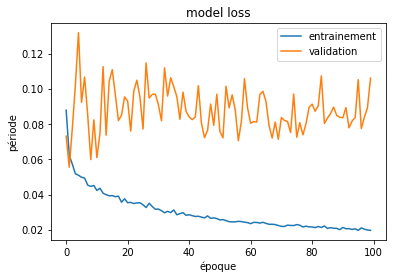

C:\Users\ste0041761\AppData\anaconda3\lib\site-packages\matplotlib\legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000002F3838C780>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


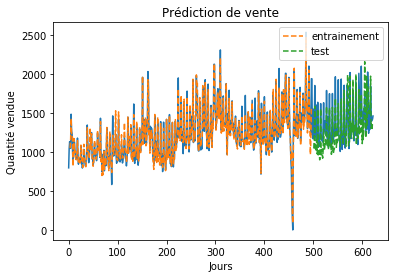

In [16]:
#Gestion des colonnes de train et de test

cln_test=111
clns_train=110

#Fonction de décalage des données

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, clns_train])
    return np.array(dataX), np.array(dataY)

#Apel des données

dataframe = pd.read_csv('Data\BDDLAST.csv', engine='python')
dataset = dataframe.values

#Normalisation des données

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#Split des données

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

#Modification des données: X=t and Y=t+1

look_back = 3
trainX, trainY = create_dataset(train, look_back)  
testX, testY = create_dataset(test, look_back)

print(trainX.shape)

#Création des variables

trainX = np.reshape(trainX, (trainX.shape[0], look_back, cln_test))
testX = np.reshape(testX, (testX.shape[0],look_back, cln_test))

#Entrainement du modèle avec LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(look_back,cln_test)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history= model.fit(trainX, trainY, validation_split=0.005, nb_epoch=100, batch_size=1)

#Affichage des courbes de perte

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('période')
plt.xlabel('époque')
plt.legend(['entrainement', 'validation'], loc='upper right')
plt.show()

#Récupération des données

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#Chemin inverse de la scalérisation

trainPredict_extended = np.zeros((len(trainPredict),cln_test))
trainPredict_extended[:,clns_train] = trainPredict[:,0]
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,clns_train] 
testPredict_extended = np.zeros((len(testPredict),cln_test))
testPredict_extended[:,clns_train] = testPredict[:,0]
testPredict = scaler.inverse_transform(testPredict_extended)[:,clns_train]   

trainY_extended = np.zeros((len(trainY),cln_test))
trainY_extended[:,clns_train]=trainY
trainY=scaler.inverse_transform(trainY_extended)[:,clns_train]

testY_extended = np.zeros((len(testY),cln_test))
testY_extended[:,clns_train]=testY
testY=scaler.inverse_transform(testY_extended)[:,clns_train]

# Récupération des données d'affichage

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, clns_train] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, clns_train] = testPredict

#Affichage de réel/predit

serie=plt.plot(scaler.inverse_transform(dataset)[:,clns_train])  
predict_entert,=plt.plot(trainPredictPlot[:,clns_train],linestyle='--')  
predict_test,=plt.plot(testPredictPlot[:,clns_train],linestyle='--')
plt.title('Prédiction de vente')
plt.ylabel('Quantité vendue')
plt.xlabel('Jours')
plt.legend([serie,predict_entert,predict_test],['serie','entrainement','test'], loc='upper right')

In [17]:
#Calcul de l'erreur moyenne

filteredTestPredict = testPredict[testY != 0]
filteredTestReal = testY[testY != 0]

mean_err = np.mean(abs((filteredTestPredict / filteredTestReal) - 1)) * 100
print('Erreur moyenne: {:.1f}%'.format(mean_err))
print('Accurate: {:.1f}%'.format(100-mean_err))

Erreur moyenne: 11.8%
Accurate: 88.2%
